Actor-critic cartesian rocket
---

In [205]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [431]:
class cartesian_rocket:
    def __init__(self,
                 dry_mass = 10.,
                 wet_mass = 50.,
                 isp = 500.,
                 time_step = 0.1,
                 drag_coef = 0.75,
                 max_fuel_rate = .75, # per second
#                  throttle_rate = 0.1 #increase of fuel use 
                 reference_height = 200, #m, for barometric pressure
                 g = 9.81
                ):
        self.dry_mass = dry_mass
        self.wet_mass = wet_mass
        self.isp = isp
        self.time_step = time_step
        self.drag_coef = drag_coef
        self.max_fuel_rate = max_fuel_rate
#         self.throttle_rate = throttle_rate
        
        #keep track of time
        self.stopwatch = 0.
        
        #keep track of velocity
        self.velocity = np.array([0.,0.])
        
        #keep track of position
        self.position = np.array([0.,0.])
        
        #drag
        self.area = 1.
        self.reference_height = reference_height
        
        #gravity
        self.g = np.array([0., -g])
        
        #history.
        self.history_position = [
            self.position
        ]
        self.history_velocity = [
            self.velocity
        ]
        
        right = np.array([1.,0.])
        up = np.array([0.,1.])
        self.directions = {
            1:right,
            2:up,
            3:-right,
            4:-up
        }
    
    #increase fuel in direction. Adds to velocity at the cost of fuel
    def fire(self, direction_code):
        direction = self.directions[direction_code]
        fuel_used = self.max_fuel_rate * self.time_step
        if fuel_used > self.wet_mass:
            fuel_used = self.wet_mass
        self.wet_mass = self.wet_mass - fuel_used
        impulse = direction*self.time_step*self.isp*np.linalg.norm(self.g)*fuel_used
        accel = impulse / (self.wet_mass + self.dry_mass)
        self.velocity = self.velocity + accel
        return accel
        
    def apply_drag(self):
        atm = np.exp(-self.position[1]/self.reference_height)
        drag_force = -0.5*atm*self.drag_coef*self.area*np.linalg.norm(self.velocity)*self.velocity
        drag_dv =  self.time_step*drag_force / (self.wet_mass + self.dry_mass)
        drag_dv_norm = np.linalg.norm(drag_dv)
        velocity_norm = np.linalg.norm(self.velocity)
        if drag_dv_norm > 0.25*velocity_norm:
            print(f'Warning: drag dv is {100*drag_dv_norm/velocity_norm}% of velocity.')
        self.velocity = self.velocity + drag_dv
    
    def apply_gravity(self):
        accel = self.time_step*self.g
        self.velocity = self.velocity + accel
        return accel
    
    def advance(self, report = True):
#         self.apply_gravity()
#         self.apply_drag()
        self.position = self.position + self.velocity * self.time_step 
        self.history_position.append(self.position)
        self.history_velocity.append(self.velocity)
        self.stopwatch += self.time_step
        if report:
            state = np.array([self.position, self.velocity, [self.dry_mass, self.wet_mass]])
            state = np.reshape(state, (1,6,))                
            return state
        
    def is_crashed(self, ground_level):
        if self.position[1] < ground_level:
            return True
        else:
            return False
    
    def plot_trajectory(self, label = None, to_show = True, figsize = (12,12)):
        x = np.array(self.history_position)[:,0]
        y = np.array(self.history_position)[:,1]
        if to_show:
            plt.figure(figsize = figsize)
            plt.plot(x,y, label = label)
            plt.show()
        else:
            plt.plot(x,y, label = label)

In [432]:
#inputs are the state of the rocket. Six values returned from advance()
num_inputs = 6
#actions are fire right, up, left, down, none
num_actions = 5
num_hidden = 32


init_seed = 20221
initializer = tf.initializers.he_normal(init_seed)

inputs = keras.layers.Input(shape = (num_inputs,))
common1 = keras.layers.Dense(num_hidden, activation = 'relu', kernel_initializer=initializer)(inputs)
actor = keras.layers.Dense(num_actions, activation = 'softmax')(common1)
critic = keras.layers.Dense(1)(common1)
# common2 = keras.layers.Dense(num_hidden, activation = 'relu', kernel_initializer=initializer, bias_initializer=initializer)(common1)
# actor = keras.layers.Dense(num_actions, activation = 'softmax', kernel_initializer=initializer, bias_initializer=initializer)(common2)
# critic = keras.layers.Dense(1)(common2)
#
model = keras.Model(inputs = inputs, outputs = [actor, critic])
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 dense_81 (Dense)               (None, 32)           224         ['input_28[0][0]']               
                                                                                                  
 dense_82 (Dense)               (None, 5)            165         ['dense_81[0][0]']               
                                                                                                  
 dense_83 (Dense)               (None, 1)            33          ['dense_81[0][0]']               
                                                                                           

In [433]:
target_vel = np.array([100., 10.])
target_alt = np.array([-60.])

#gives error values for the velocity and altitude
def calculate_errors(rocket_state, target_velocity = target_vel, target_altitude = target_alt):
    pos_x, altitude, vel_x, vel_y, dry_mass, wet_mass = rocket_state[0]
#     velocity = np.array([vel_x, vel_y])
#     speed_square_error =  np.linalg.norm(velocity - target_velocity)**2
    speed_square_error =  (vel_x - target_velocity[0])**2 + (vel_y - target_velocity[1])**2
    altitude_square_error = (altitude - target_altitude)**2
    return speed_square_error, altitude_square_error
    

In [434]:
seed = 2022
rng = np.random.default_rng(seed)


gamma = 0.5
max_simulation_time = 60*1 #seconds
eps = np.finfo(np.float32).eps.item()


huber = tf.losses.Huber()

average loss: 85618.23/sec at episode 10, rocket lasted 60.0 sec, last action 2, last accel [0.         2.17035398]
average loss: 117728.45/sec at episode 20, rocket lasted 60.0 sec, last action 2, last accel [0.         1.43421053]


KeyboardInterrupt: 

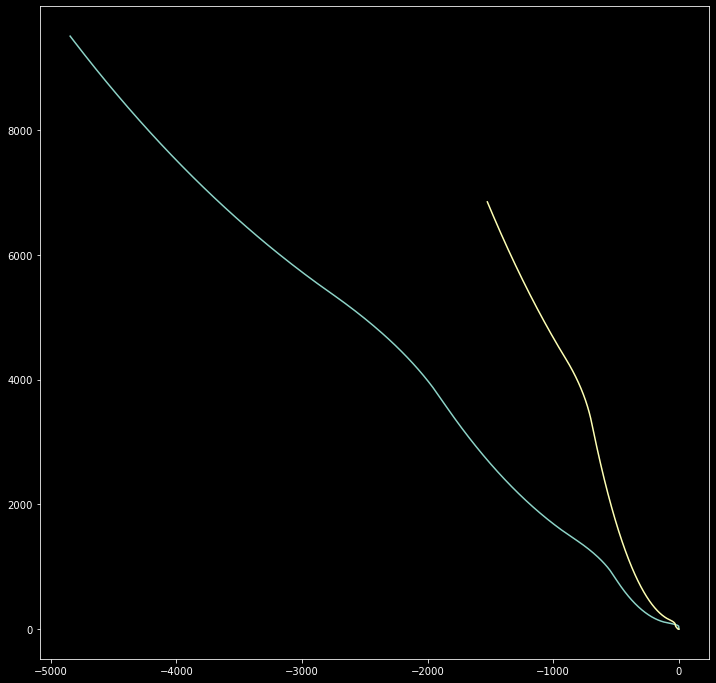

In [435]:
############################
#losses and rewards
############################


action_probs_history = []
critic_value_history = []
rewards_history = []




############################
#optimizer and learning rate
############################


# # is_learning_rate_decaying = False
# # # is_learning_rate_decaying = True
# learning_rate_start = 0.001
# # learning_rate_end = 0.0001

# if is_learning_rate_decaying:
#     learning_rate_decay = (learning_rate_end/learning_rate_start)**(1/num_episodes)
# else:
#     learning_rate_decay = 1



optimizer = tf.optimizers.Adam(learning_rate =.01)
#                               beta_1=0.999,
#                               beta_2=0.9,
#                                epsilon=1e-06,
#                               amsgrad=False)

# optimizer = tf.optimizers.Adam(learning_rate = learning_rate_start, beta_1 = learning_rate_decay)

############################
# number of episodes
############################

num_episodes = 100
episode_update_period = 10
episode_count = 0


############################
#go
############################
plt.figure(figsize = (12,12))

for epoch in range(num_episodes):
    rkt = cartesian_rocket()
    rkt.velocity = (rng.random(2)-np.array([0.5,0.]))*5
    starting_state = np.array([rkt.position, rkt.velocity, [rkt.dry_mass, rkt.wet_mass]])
    starting_state = np.reshape(starting_state, (1,6))
    state = tf.convert_to_tensor(starting_state)
    
    episode_reward = 0
    
    with tf.GradientTape() as tape:
        while not rkt.is_crashed(ground_level = -25.) and rkt.stopwatch < max_simulation_time:
                
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0,0])

            action = rng.choice(num_actions, p = np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            #fire in the appropriate direction unless the action is number 0: coast
            if action == 0:
                accel = np.array([0.,0.])
            else:
                accel = rkt.fire(action)

            state = rkt.advance()
            
            velocity_error, altitude_error = calculate_errors(state)
            total_error = velocity_error+altitude_error-1*rkt.stopwatch
            total_reward = -total_error #100000.-total_error
            rewards_history.append(total_reward)
            episode_reward += total_reward
        
#         running_reward = 0.05 * episode_reward + (1-0.05) * running_reward
        
        rewards = []
        discounted_sum = 0
    
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma*discounted_sum
            rewards.insert(0, discounted_sum)
        rewards = np.array(rewards)
        rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + eps)
        rewards = rewards.tolist()
        
        history = zip(action_probs_history, critic_value_history, rewards)
        actor_losses = []
        critic_losses = []
        for log_prob, critic_reward, true_reward in history:
            abs_diff = abs(true_reward - critic_reward)
#             diff = true_reward - critic_reward
#             actor_losses.append(-log_prob*abs_diff)
            critic_loss = huber(tf.expand_dims(critic_reward, 0), tf.expand_dims(true_reward,0))
            critic_losses.append(
                critic_loss
            )
            actor_loss = -log_prob*abs_diff
#             actor_loss = -log_prob*diff
            actor_loss = -log_prob*critic_loss
            actor_losses.append(actor_loss)
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
               
        
    episode_count += 1
    if episode_count % episode_update_period == 0:
        template = 'average loss: {:.2f}/sec at episode {}, rocket lasted {:.1f} sec, last action {}, last accel {}'
        print(template.format(loss_value/rkt.stopwatch, episode_count, rkt.stopwatch, action, accel))
#         model.save(f'./actor_critic_rocket_models/model_{episode_count}.tf')
        rkt.plot_trajectory(label='episode {}, remaining fuel {:.2f}, stopwatch {:.1f}'.format(episode_count,rkt.wet_mass,rkt.stopwatch), to_show=False)

#         print(action_probs_history)
        
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
#     if is_learning_rate_decaying:
#         optimizer.learning_rate = optimizer.learning_rate*learning_rate_decay
# plt.xlim(-150, 1200)
# plt.ylim(-10, 120)
plt.scatter([0], [0], c='red')
plt.legend();

In [350]:
rkt.fire(2)
rkt.advance()

array([[ -2.04214275, -27.9423678 ,   6.66583454, -21.27561375,
         10.        ,  98.8       ]])

In [346]:
rkt.apply_gravity()

array([ 0.   , -0.981])

In [136]:
state

array([[-273.63438303,  -27.57583431,  -68.09279516,  -31.71414991,
          10.        ,    8.1       ]])

In [167]:
accel, state, action

(array([-0.        , -5.13075314]),
 array([[   0.        ,  -25.99530554,    0.        , -126.14658263,
           10.        ,    9.12      ]]),
 0)

In [197]:
template = 'average loss: {:.2f}/sec at episode {}, rocket lasted {:.1f} sec, last action {}, last accel {}'
print(template.format(float(loss_value/rkt.stopwatch, episode_count, rkt.stopwatch, action, accel))

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [202]:
template.format(float(loss_value)/rkt.stopwatch, episode_count, rkt.stopwatch, action, accel)

'average loss: 61.40/sec at episode 1, rocket lasted 7.1 sec, last action 3, last accel [-0.16545792 -0.        ]'

In [200]:
loss_value/rkt.stopwatch, episode_count, rkt.stopwatch, action, accel

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([61.40435], dtype=float32)>,
 1,
 7.099999999999991,
 3,
 array([-0.16545792, -0.        ]))

In [244]:
critic_reward

<tf.Tensor: shape=(), dtype=float32, numpy=2.5426826>

In [245]:
true_reward

[1.3620659101810801]

In [257]:
rewards_history

[]

In [258]:
critic_value_history

[]

In [259]:
rewards

[[-1.402463144472425],
 [-1.3088694034917534],
 [-1.2143555432482982],
 [-1.1171142457336352],
 [-1.0184792099048061],
 [-0.9174954546224412],
 [-0.8123624883732696],
 [-0.7054399244264532],
 [-0.5941247604285007],
 [-0.479576460162618],
 [-0.3612241715238818],
 [-0.235868641887273],
 [-0.103243637676741],
 [0.038087606502539506],
 [0.18859095034228132],
 [0.3468584489171301],
 [0.515003053198049],
 [0.692428114172206],
 [0.8794898493530352],
 [1.0768864771637687],
 [1.2877651290523033],
 [1.5101519039479936],
 [1.7444174195171749],
 [1.9909381337856138]]

In [407]:
rkt = cartesian_rocket()

In [418]:
rkt.fire(2)

array([ 0.        , 15.82258065])

In [425]:
rkt.advance()

array([[  0.        , 143.25092709,   0.        ,  14.3464338 ,
         10.        ,  48.125     ]])